In [2]:
import torch 
import pandas as pd
from tqdm import tqdm
from input.reading_datasets import read_dataset_from_file
from input.time_series_module import TimeSeriesDataset
from preprocessing.get_dummies_labels import GetDummiesLabels
from preprocessing.train_test_split_module import TrainTestSplit

from models.fully_convolutional_network_1dGAP import FullyConvolutionalNetwork1DGAP
from models.fully_convolutional_network_1d_intermediateGAP import FullyConvolutionalNetwork1DIntermediateGAP
from models.fully_convolutional_network_1d_lateGAP import FullyConvolutionalNetwork1DLateGAP


from torch.utils.data import DataLoader
from sklearn.metrics import f1_score


In [3]:
torch.cuda.empty_cache()

In [4]:
def get_metrics(model, device = 'cuda'):    
    
    model.eval()
    all_preds = []
    all_targets = []
    with torch.inference_mode():
        valid_loss = 0.0
        valid_correct = 0
        valid_total = 0
        for inputs, targets in model.test_dataload:
            inputs, targets = inputs.to(model.device), targets.to(model.device)
            outputs = model(inputs)
            
            loss = model.loss_fn(
                outputs.type(torch.float32), 
                targets.type(torch.float32) 
            )

            valid_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            _, target_indices = torch.max(targets, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(target_indices.cpu().numpy())

            valid_correct += (predicted == torch.max(targets, 1).indices).sum().item()
            valid_total += targets.size(0)

        valid_loss /= len(model.test_dataload)
        valid_accuracy = valid_correct / valid_total
        f1_macro = f1_score(all_targets, all_preds, average='macro')
        f1_micro = f1_score(all_targets, all_preds, average='micro')

    return {
        'f1_macro': f1_macro,
        'f1_micro': f1_micro,
        'valid_accuracy': valid_accuracy
    }

In [ ]:

def get_metrics_from_model(used_model, seeds = list(range(1, 11))):
    custom_groups = True
    batch_size = 32
    datasets = ['wesad']
    device = 'cuda'
    metrics = []
    for dataset in tqdm(datasets):
        for random_state in tqdm(seeds):
            used_dataset = read_dataset_from_file(dataset_name = dataset)
            X, y, metadata = used_dataset['X'], used_dataset['y'], used_dataset['metadata']

            get_dummies_object = GetDummiesLabels(
                X_raw= X,
                y_raw= y,
                metadata= metadata
            )

            X, y = get_dummies_object.transform()

            train_test_object = TrainTestSplit(
                X_raw= X,
                y_raw= y,
                metadata= metadata,
                random_state = random_state
                
            )

        
            X_train, X_test, y_train, y_test = train_test_object.transform(custom_groups = custom_groups)
            X_train, X_test, y_train, y_test = torch.from_numpy(X_train).to(device), torch.from_numpy(X_test).to(device), torch.from_numpy(y_train).to(device), torch.from_numpy(y_test).to(device)


            train_dataset = TimeSeriesDataset(
                data=X_train,
                labels=y_train,
                metadata=metadata
            )

            test_dataset = TimeSeriesDataset(
                data=X_test,
                labels=y_test,
                metadata=metadata
            )

    
            model = used_model(
                train_dataset = train_dataset,
                test_dataset = test_dataset,
                metadata = metadata,
                random_state = random_state,
                dataset_name = dataset,
                device = device
            ).to(device)

            

            model_name = model.model_name
            
            model.eval()
            load_model = torch.load(f = './model_checkpoints/' + model.model_folder + '/best_model.pth') 
            model.load_state_dict(load_model)

            
            metrics_seed = get_metrics(model=model)
            metrics.append(metrics_seed)
            print(random_state, metrics_seed)

            del X_train, X_test, y_train, y_test
            del model

    df = pd.DataFrame(metrics, index = seeds)
    df['model_name'] = model_name

    return df



In [6]:
models_metrics = []
for used_model in [FullyConvolutionalNetwork1DGAP, FullyConvolutionalNetwork1DIntermediateGAP, FullyConvolutionalNetwork1DLateGAP]:
    models_metrics.append(get_metrics_from_model(used_model = used_model, seeds = list(range(1, 11))))


  0%|          | 0/1 [00:00<?, ?it/s]/tmp/ipykernel_3424418/1431452037.py:61: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_model = torch.load(f = './model_checkpoints/

1 {'f1_macro': 0.9956447491571239, 'f1_micro': 0.9966759002770084, 'valid_accuracy': 0.9966759002770084}


/tmp/ipykernel_3424418/1431452037.py:61: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_model = torch.load(f = './model_checkpoints/' + model.model_folder + '/best_model

2 {'f1_macro': 0.5229956512168681, 'f1_micro': 0.6166445329791943, 'valid_accuracy': 0.6166445329791943}


/tmp/ipykernel_3424418/1431452037.py:61: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_model = torch.load(f = './model_checkpoints/' + model.model_folder + '/best_model

3 {'f1_macro': 0.5894117178858617, 'f1_micro': 0.7024084460574068, 'valid_accuracy': 0.7024084460574068}


/tmp/ipykernel_3424418/1431452037.py:61: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_model = torch.load(f = './model_checkpoints/' + model.model_folder + '/best_model

4 {'f1_macro': 0.6029085859418989, 'f1_micro': 0.6301986173598156, 'valid_accuracy': 0.6301986173598156}


/tmp/ipykernel_3424418/1431452037.py:61: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_model = torch.load(f = './model_checkpoints/' + model.model_folder + '/best_model

5 {'f1_macro': 0.5599112604147107, 'f1_micro': 0.5760640071119013, 'valid_accuracy': 0.5760640071119013}


/tmp/ipykernel_3424418/1431452037.py:61: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_model = torch.load(f = './model_checkpoints/' + model.model_folder + '/best_model

6 {'f1_macro': 0.6042864515211213, 'f1_micro': 0.7438254513235131, 'valid_accuracy': 0.7438254513235131}


/tmp/ipykernel_3424418/1431452037.py:61: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_model = torch.load(f = './model_checkpoints/' + model.model_folder + '/best_model

7 {'f1_macro': 0.6218060919217957, 'f1_micro': 0.639155894376312, 'valid_accuracy': 0.639155894376312}


/tmp/ipykernel_3424418/1431452037.py:61: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_model = torch.load(f = './model_checkpoints/' + model.model_folder + '/best_model

8 {'f1_macro': 0.5587383119511024, 'f1_micro': 0.6044602241207145, 'valid_accuracy': 0.6044602241207145}


/tmp/ipykernel_3424418/1431452037.py:61: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_model = torch.load(f = './model_checkpoints/' + model.model_folder + '/best_model

9 {'f1_macro': 0.4885469582564053, 'f1_micro': 0.5734750979294908, 'valid_accuracy': 0.5734750979294908}


/tmp/ipykernel_3424418/1431452037.py:61: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_model = torch.load(f = './model_checkpoints/' + model.model_folder + '/best_model

10 {'f1_macro': 0.5168791915493607, 'f1_micro': 0.614608734205276, 'valid_accuracy': 0.614608734205276}


  0%|          | 0/1 [00:00<?, ?it/s]/tmp/ipykernel_3424418/1431452037.py:61: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_model = torch.load(f = './model_checkpoints/

1 {'f1_macro': 0.8230223123322622, 'f1_micro': 0.8646491519787163, 'valid_accuracy': 0.8646491519787163}


/tmp/ipykernel_3424418/1431452037.py:61: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_model = torch.load(f = './model_checkpoints/' + model.model_folder + '/best_model

2 {'f1_macro': 0.563036565090653, 'f1_micro': 0.6266046923417441, 'valid_accuracy': 0.6266046923417441}


/tmp/ipykernel_3424418/1431452037.py:61: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_model = torch.load(f = './model_checkpoints/' + model.model_folder + '/best_model

3 {'f1_macro': 0.680226164140454, 'f1_micro': 0.7948971736500605, 'valid_accuracy': 0.7948971736500605}


/tmp/ipykernel_3424418/1431452037.py:61: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_model = torch.load(f = './model_checkpoints/' + model.model_folder + '/best_model

4 {'f1_macro': 0.5638993600150043, 'f1_micro': 0.617250082300011, 'valid_accuracy': 0.617250082300011}


/tmp/ipykernel_3424418/1431452037.py:61: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_model = torch.load(f = './model_checkpoints/' + model.model_folder + '/best_model

5 {'f1_macro': 0.5960898788816837, 'f1_micro': 0.6812979219913323, 'valid_accuracy': 0.6812979219913323}


/tmp/ipykernel_3424418/1431452037.py:61: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_model = torch.load(f = './model_checkpoints/' + model.model_folder + '/best_model

6 {'f1_macro': 0.738697198527835, 'f1_micro': 0.838077306456972, 'valid_accuracy': 0.838077306456972}


/tmp/ipykernel_3424418/1431452037.py:61: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_model = torch.load(f = './model_checkpoints/' + model.model_folder + '/best_model

7 {'f1_macro': 0.6168346621337923, 'f1_micro': 0.7174897801347917, 'valid_accuracy': 0.7174897801347917}


/tmp/ipykernel_3424418/1431452037.py:61: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_model = torch.load(f = './model_checkpoints/' + model.model_folder + '/best_model

8 {'f1_macro': 0.574303939101507, 'f1_micro': 0.6023521579940087, 'valid_accuracy': 0.6023521579940087}


/tmp/ipykernel_3424418/1431452037.py:61: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_model = torch.load(f = './model_checkpoints/' + model.model_folder + '/best_model

9 {'f1_macro': 0.6886032601079233, 'f1_micro': 0.7509792949076665, 'valid_accuracy': 0.7509792949076665}


/tmp/ipykernel_3424418/1431452037.py:61: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_model = torch.load(f = './model_checkpoints/' + model.model_folder + '/best_model

10 {'f1_macro': 0.5676576831618836, 'f1_micro': 0.6440922190201729, 'valid_accuracy': 0.6440922190201729}


  0%|          | 0/1 [00:00<?, ?it/s]/tmp/ipykernel_3424418/1431452037.py:61: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_model = torch.load(f = './model_checkpoints/

1 {'f1_macro': 0.999170206198816, 'f1_micro': 0.9993348852677086, 'valid_accuracy': 0.9993348852677086}


/tmp/ipykernel_3424418/1431452037.py:61: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_model = torch.load(f = './model_checkpoints/' + model.model_folder + '/best_model

2 {'f1_macro': 0.5483481450601417, 'f1_micro': 0.6458610004426738, 'valid_accuracy': 0.6458610004426738}


/tmp/ipykernel_3424418/1431452037.py:61: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_model = torch.load(f = './model_checkpoints/' + model.model_folder + '/best_model

3 {'f1_macro': 0.6794299762566915, 'f1_micro': 0.7621247113163973, 'valid_accuracy': 0.7621247113163973}


/tmp/ipykernel_3424418/1431452037.py:61: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_model = torch.load(f = './model_checkpoints/' + model.model_folder + '/best_model

4 {'f1_macro': 0.55601750766023, 'f1_micro': 0.6348074179743224, 'valid_accuracy': 0.6348074179743224}


/tmp/ipykernel_3424418/1431452037.py:61: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_model = torch.load(f = './model_checkpoints/' + model.model_folder + '/best_model

5 {'f1_macro': 0.5600453359918707, 'f1_micro': 0.6440715635070563, 'valid_accuracy': 0.6440715635070563}


/tmp/ipykernel_3424418/1431452037.py:61: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_model = torch.load(f = './model_checkpoints/' + model.model_folder + '/best_model

6 {'f1_macro': 0.7644605577320005, 'f1_micro': 0.8327611031121941, 'valid_accuracy': 0.8327611031121941}


/tmp/ipykernel_3424418/1431452037.py:61: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_model = torch.load(f = './model_checkpoints/' + model.model_folder + '/best_model

7 {'f1_macro': 0.6794984759609375, 'f1_micro': 0.7286487680919236, 'valid_accuracy': 0.7286487680919236}


/tmp/ipykernel_3424418/1431452037.py:61: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_model = torch.load(f = './model_checkpoints/' + model.model_folder + '/best_model

8 {'f1_macro': 0.5847152302001012, 'f1_micro': 0.6239875735049373, 'valid_accuracy': 0.6239875735049373}


/tmp/ipykernel_3424418/1431452037.py:61: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_model = torch.load(f = './model_checkpoints/' + model.model_folder + '/best_model

9 {'f1_macro': 0.6393019458905429, 'f1_micro': 0.7169557918298824, 'valid_accuracy': 0.7169557918298824}


/tmp/ipykernel_3424418/1431452037.py:61: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_model = torch.load(f = './model_checkpoints/' + model.model_folder + '/best_model

10 {'f1_macro': 0.565424172465497, 'f1_micro': 0.6852139215251607, 'valid_accuracy': 0.6852139215251607}


In [17]:
df_complete = pd.DataFrame()

for df in models_metrics:
    df_complete = pd.concat([df_complete, df], axis = 0)

df_complete.reset_index(names = 'seed', inplace=True)

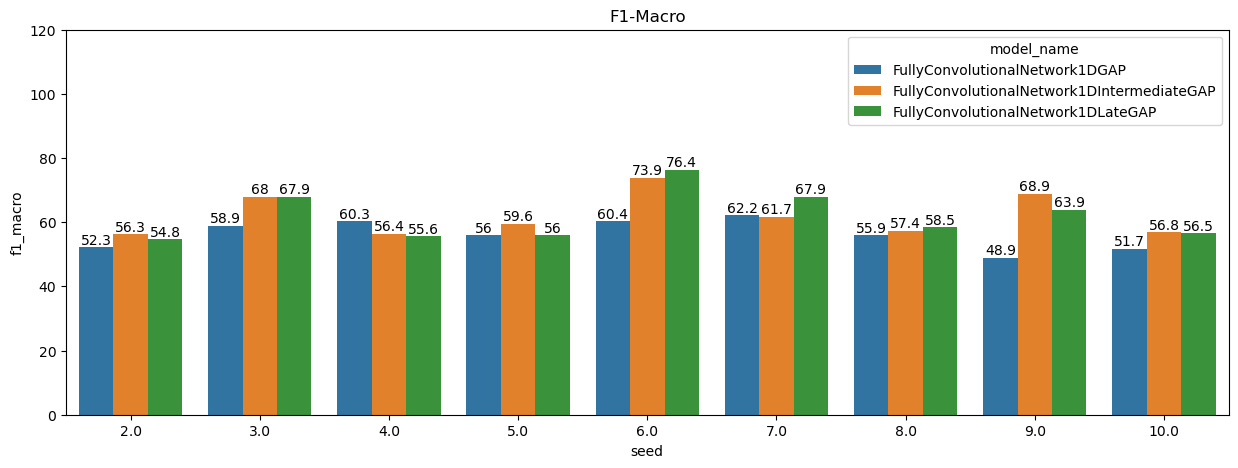

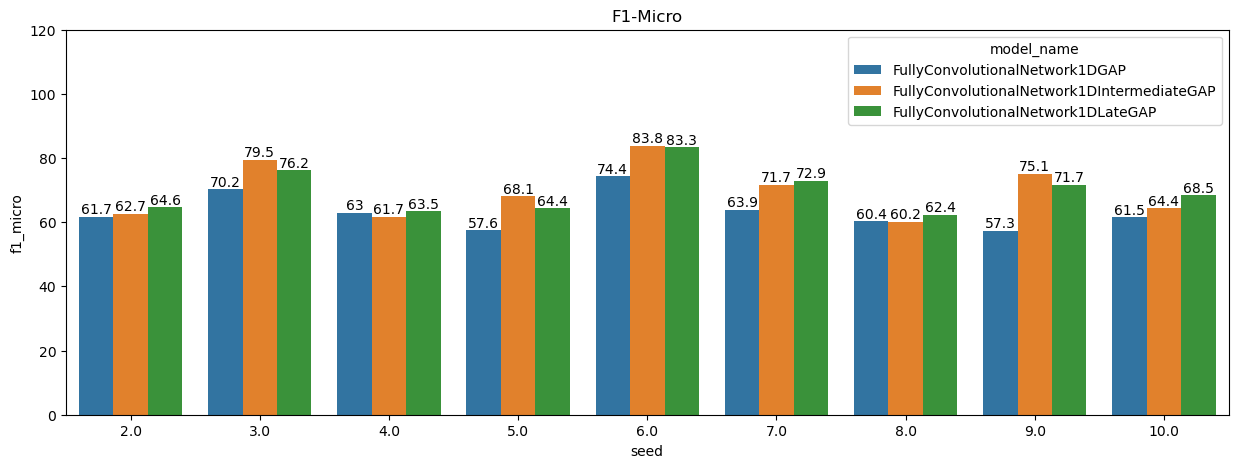

In [43]:
import seaborn as sns 
import matplotlib.pyplot as plt

plt.figure(figsize = (15,5 ))

ax = sns.barplot(
    data = df_complete.query("seed != 1"),
    x= 'seed',
    y = df_complete.f1_macro.apply(lambda x: round(x*100, 1)),
    hue = 'model_name'
)
plt.title('F1-Macro')

plt.ylim([0,120])

for i in ax.containers:
    ax.bar_label(i,)

plt.show()


plt.figure(figsize = (15,5 ))

ax = sns.barplot(
    data = df_complete.query("seed != 1"),
    x= 'seed',
    y = df_complete.f1_micro.apply(lambda x: round(x*100, 1)),
    hue = 'model_name'
)
plt.title('F1-Micro')

plt.ylim([0,120])

for i in ax.containers:
    ax.bar_label(i,)

plt.show()


In [40]:
seeds = list(range(1, 2))
used_model = FullyConvolutionalNetwork1DGAP
custom_groups = True
batch_size = 32
datasets = ['wesad']
device = 'cuda'
metrics = []
for dataset in tqdm(datasets):
    for random_state in tqdm(seeds):
        used_dataset = read_dataset_from_file(dataset_name = dataset)
        X, y, metadata = used_dataset['X'], used_dataset['y'], used_dataset['metadata']

        get_dummies_object = GetDummiesLabels(
            X_raw= X,
            y_raw= y,
            metadata= metadata
        )

        X, y = get_dummies_object.transform()

        train_test_object = TrainTestSplit(
            X_raw= X,
            y_raw= y,
            metadata= metadata,
            random_state = random_state
            
        )

    
        X_train, X_test, y_train, y_test = train_test_object.transform(custom_groups = custom_groups)
        X_train, X_test, y_train, y_test = torch.from_numpy(X_train).to(device), torch.from_numpy(X_test).to(device), torch.from_numpy(y_train).to(device), torch.from_numpy(y_test).to(device)


        train_dataset = TimeSeriesDataset(
            data=X_train,
            labels=y_train,
            metadata=metadata
        )

        test_dataset = TimeSeriesDataset(
            data=X_test,
            labels=y_test,
            metadata=metadata
        )

100%|██████████| 1/1 [00:02<00:00,  2.15s/it]
